In [ ]:
import random, os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import imageio.v3 as imageio
from render.CollectFrames import collect_saved_frames
matplotlib.use('Agg')
random.seed(42)
np.random.seed(42)

#### Function to generate random grid

In [2]:
def get_random_grid(grid_size: int, obstacle_chance: float):
    # Generate random grid with obstacles
    grid = np.zeros((grid_size, grid_size), dtype=int)
    grid[np.random.rand(grid_size, grid_size) < obstacle_chance] = 1
    # Place cheese completely randomly
    cheese_pos = (np.random.randint(0, grid_size), np.random.randint(0, grid_size))
    grid[cheese_pos[0], cheese_pos[1]] = 2
    # Place mouse in the corner furthest from the cheese
    corners = [(0, 0), (0, grid_size - 1), (grid_size - 1, 0), (grid_size - 1, grid_size - 1)]
    distances = [abs(corner[0] - cheese_pos[0]) + abs(corner[1] - cheese_pos[1]) for corner in corners] 
    mouse_pos = corners[np.argmax(np.array(distances))]
    # Ensure there is not obstacle at initial mouse position
    grid[mouse_pos] = 0
    return grid, mouse_pos

#### Generator function to Q-Train the mouse

In [ ]:
def q_learn_maze(
        grid: np.ndarray,
        mouse_pos: tuple,
        max_steps: int,
        iters=100,
        lrn_rate=0.1,
        disc_factor=0.9,
        epsilon=0.1):
    actions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
    q_table = np.zeros((len(grid), len(grid), 4))
    for iteration in range(iters):
        state = list(mouse_pos)
        total_reward = 0
        for _ in range(max_steps):
            # Choose between exploitation and exploration and pick action
            explore = random.uniform(0, 1) < epsilon
            action = random.randint(0, 3) if explore else np.argmax(q_table[state[0], state[1]])
            # Calculate position and check if it's not a wall
            next = (actions[action][0] + state[0], actions[action][1] + state[1])
            is_oob = next[0] < 0 or next[0] >= len(grid) or next[1] < 0 or next[1] >= len(grid)
            # Decide reward for the move
            reward = -1
            if is_oob or grid[next[0]][next[1]] == 1:
                reward = -10
            elif grid[next[0]][next[1]] == 2:
                reward = 1000
            # Update the current state in the Q-table using Bellman equation
            current = q_table[state[0], state[1], action]
            best_next = 0 if is_oob or reward == 1000 else np.max(q_table[next[0], next[1]])
            update = lrn_rate * (0.01 * reward + disc_factor * best_next - current)
            q_table[state[0], state[1], action] += update
            # Update the reward and decide move
            total_reward += reward
            yield iteration, state, total_reward, False, q_table
            if reward != -10:
                state = next
            if reward == 1000:
                break
        yield iteration, state, total_reward, True, q_table

#### Function to capture the grid as frame

In [4]:
def capture_grid_frame(grid, mouse_pos, iteration, total_reward):
    original_value = grid[mouse_pos[0], mouse_pos[1]]
    grid[mouse_pos[0], mouse_pos[1]] = 3
    fig_grid, ax_grid = plt.subplots(figsize=(5, 5), dpi=90)
    colors = ['white', 'black', 'yellow', 'red']
    cmap_grid = mcolors.ListedColormap(colors)
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = mcolors.BoundaryNorm(bounds, cmap_grid.N)
    ax_grid.imshow(grid, cmap=cmap_grid, norm=norm, interpolation='nearest')
    ax_grid.set_xticks([])
    ax_grid.set_yticks([])
    cond_string = "Reward" if total_reward >= 0 else "Penalisation"
    ax_grid.set_title(f"Iteration: {iteration} | Total {cond_string}: {abs(total_reward)}")
    plt.tight_layout()
    fig_grid.canvas.draw()
    frame = np.array(fig_grid.canvas.buffer_rgba())
    plt.close(fig_grid)
    grid[mouse_pos[0], mouse_pos[1]] = original_value
    return frame

#### Generate random grid

In [6]:
grid, mouse_pos = get_random_grid(10, 0.3)

#### Q-Train the mouse and collect frames

In [ ]:
folder_path = "gifs/maze/"
os.makedirs(folder_path, exist_ok=True)
rewards = []

In [8]:
for idx, (it, pos, reward, is_last, q_table) in enumerate(q_learn_maze(grid, mouse_pos, 500, 100)):
    frame = capture_grid_frame(grid, pos, it, reward)
    imageio.imwrite(os.path.join(folder_path, f"MazeQlearning{idx:08d}.png"), frame)
    if is_last:
        rewards.append(reward)

In [9]:
gif_filename = "MazeQlearning.gif"
collect_saved_frames(folder_path, gif_filename)

#### Visualize the learning process

![Maze Qlearning](gifs/maze/MazeQlearning.gif)

#### Visualize total rewards over time

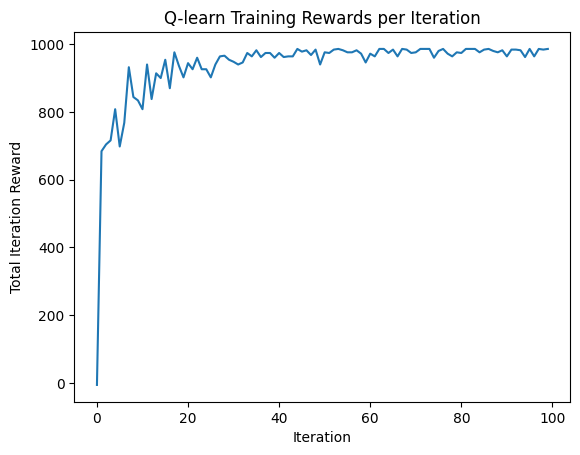

In [11]:
%matplotlib inline
plt.plot(rewards)
plt.xlabel('Iteration')
plt.ylabel('Total Iteration Reward')
plt.title('Q-learn Training Rewards per Iteration')
plt.show()

#### Visualize the final Q-Table

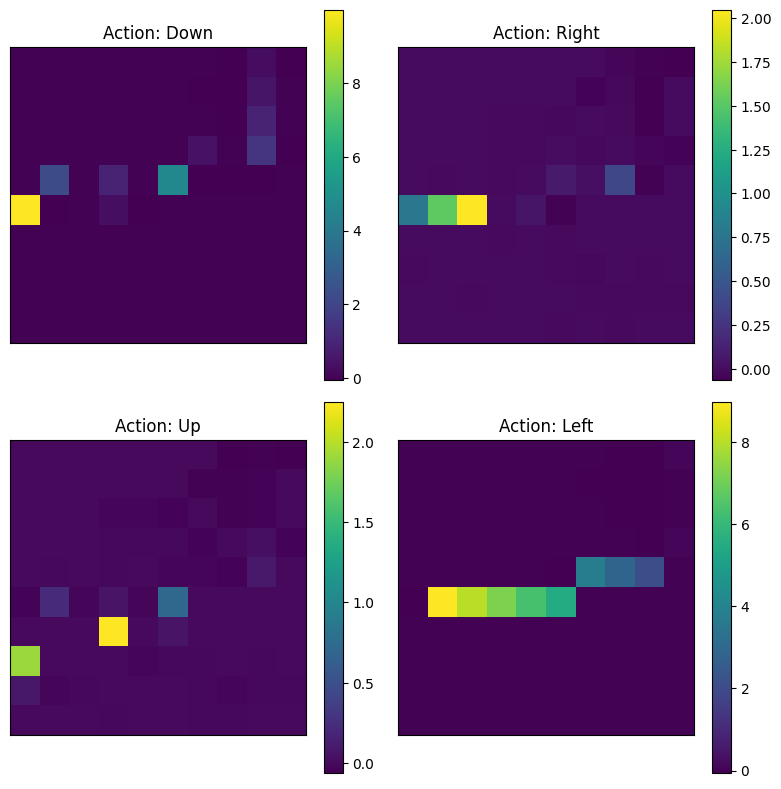

In [12]:
%matplotlib inline
actions = ["Down", "Right", "Up", "Left"] 
fig_q, axes_q = plt.subplots(2, 2, figsize=(8, 8))
axes_q = axes_q.flatten()
num_actions = q_table.shape[2]
for i in range(num_actions):
    ax = axes_q[i] 
    im = ax.imshow(q_table[:, :, i], cmap='viridis', interpolation='nearest')
    fig_q.colorbar(im, ax=ax)
    ax.set_title(f'Action: {actions[i]}') 
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()